# 🔎**CareerVillage.org Recommendation System**🔍
![Imgur](https://i.imgur.com/oA5T6RX.jpg)

 **Objective:** To develop a method to recommend relevant questions on CareerVillage.com to the professionals who are most likely to answer them.

# **Approach:**



**************************************************************************************************************************************************************************************
[Solution 1:](#1) 

Find questions similar to the one asked, and track down professionals who answered those questions.

👍**Pros:**  ❗❗New Feature Alert❗❗ This can be used to add a feature in the system that suggests the student similar questions asked in the past to check if the question is similar to any existing questions and they could be given a chance to take a look at the responses of the previous questions before posting the question. 

⌛**Added bonus:**⌛
If they are satisfied with those answers, they can then skip posting the question in the forum, thereby saving valuable time of our professionals a.k.a Superheroes and also avoids duplication of questions in the forum. 

👎**Cons:** 

**COLD-START PROBLEM:**This method will not suggest professionals who haven't made any responses yet. This issue will be handled under Solution 2.

***************************************************************************************************************************************************************************************
[Solution 2:](#2) 

Professionals have tags to indicate topics of interest. We can check for similarity betweeen the question posted and the professionals' tags.

👍**Pros:** This method will not take into account whether the professionals have made any responses in the past.

👎**Cons:** This method will not suggest professionals who do not have any tags.

****************************************************************************************************************************************************************************************
[Solution 3:](#3) 

Market-Basket/ Association analysis: 

Suggest questions similar to the ones answered by professionals with similar tags.

👍**Pros:** This method will include professionls who do not have any activity on the platform.



****************************************************************************************************************************************************************************************


✅  A combination of the results from these methods should be a good start.



⭐  **NO QUESTION LEFT BEHIND AND NO PROFESSIONAL IGNORED**  ⭐ 

On a daily and weekly basis, make a list of questions which haven't received any reponses.

Based on the email frequency each professional has opted for, group them into daily and weekly categories.

There are professionals who have opted for immediate notification - there should be a cut-off level set on this to limit the number of emails sent on a day.

May be once or twice by default (could also ask the professional for their input as well)

Find the most relevant questions for each professional based on their answering history and recommend questions which are most similar to the questions answered in the past from the 'no-responses' list created before.

In this way, no professional will get ignored and can also try to engage professionals who have been inactive for a while. 

**IMPORT REQUIRED LIBRARIES**

In [4]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gensim
from nltk.tokenize import word_tokenize
import dateutil.parser
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
from matplotlib.pyplot import figure
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

# **Data Exploration**

**AVAILABLE FILES**

In [5]:
print(os.listdir("../input"))
pro= pd.read_csv('../input/professionals.csv')
stu=pd.read_csv("../input/students.csv")

qs=pd.read_csv("../input/questions.csv")
ans= pd.read_csv('../input/answers.csv')
com= pd.read_csv('../input/comments.csv')
email= pd.read_csv('../input/emails.csv')
match= pd.read_csv('../input/matches.csv')

school_mem= pd.read_csv('../input/school_memberships.csv')

tags= pd.read_csv('../input/tags.csv')
qs_tags=pd.read_csv('../input/tag_questions.csv')
user_tag=pd.read_csv('../input/tag_users.csv')

['professionals.csv', 'groups.csv', 'comments.csv', 'school_memberships.csv', 'tags.csv', 'emails.csv', 'group_memberships.csv', 'answers.csv', 'answer_scores.csv', 'question_scores.csv', 'students.csv', 'matches.csv', 'questions.csv', 'tag_users.csv', 'tag_questions.csv']


**SIZE OF THE COMMUNITY**

In [6]:
print("Number of students registered:",stu['students_id'].count())
print("Number of professional registered:",pro['professionals_id'].count())

Number of students registered: 30971
Number of professional registered: 28152


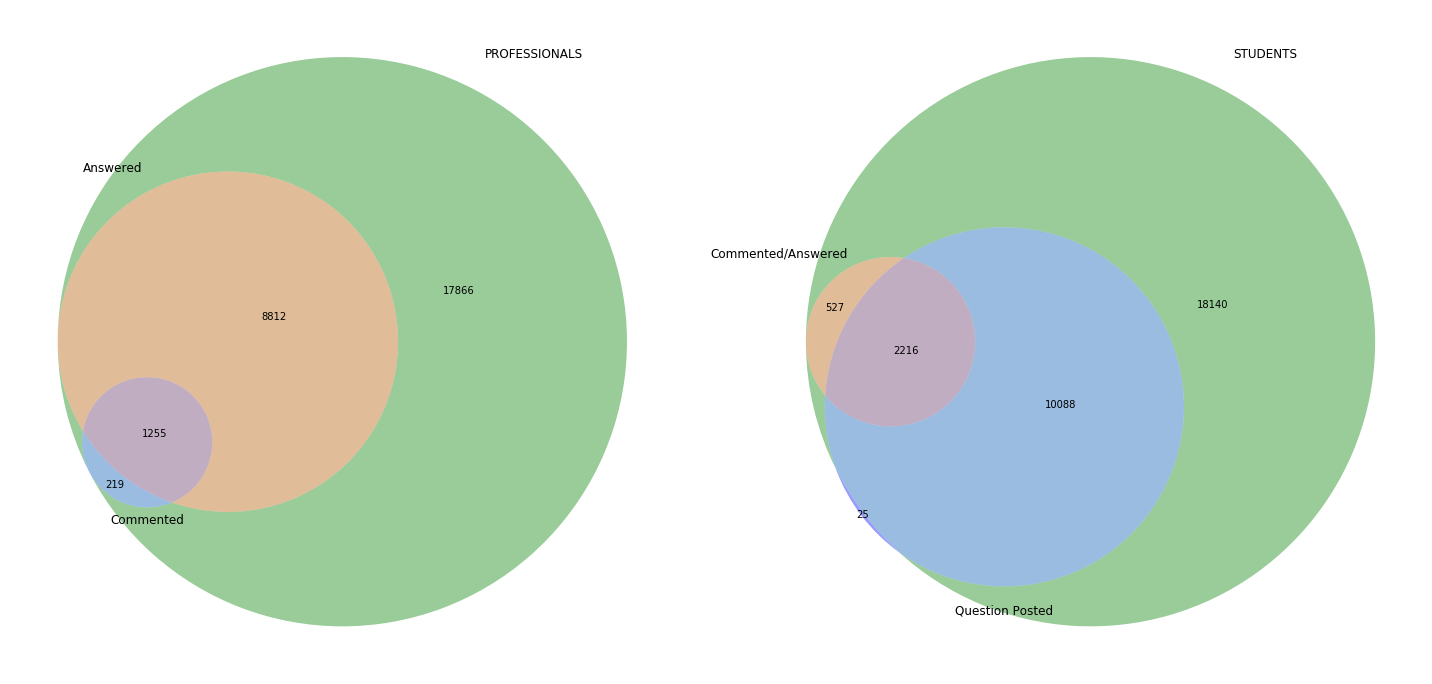

In [7]:
ans_stu= pd.merge(ans,stu, left_on='answers_author_id',right_on='students_id')
ans_pro= pd.merge(ans,pro, left_on='answers_author_id',right_on='professionals_id')

com_stu= pd.merge(com,stu, left_on='comments_author_id',right_on='students_id')
com_pro= pd.merge(com,pro, left_on='comments_author_id',right_on='professionals_id')

active_pro= set(ans_pro['answers_author_id']).union(set(com_pro['comments_author_id']))
active_stu= set(ans_stu['answers_author_id']).union(set(com_stu['comments_author_id']))

figure(figsize=(20,20))
plt.subplot(1, 2, 1)
venn3([set(ans_pro['answers_author_id']), set(pro['professionals_id']),set(com_pro['comments_author_id'])],
      set_labels = ('Answered','PROFESSIONALS','Commented'))

plt.subplot(1, 2, 2)
venn3([set(active_stu), set(stu['students_id']), set(qs['questions_author_id'])],
      set_labels = ('Commented/Answered','STUDENTS','Question Posted' ))

plt.tight_layout()
plt.show()


~18k professionals and ~18.6k students haven't contributed in anyway- no questions/answers/comments.

Only about ~36% of the professionals and ~36% of students have engaged in the platform.

⭐  **NEW DATA FEATURE ALERT**  ⭐ 

An **'activity indicator'** could be added as a feature to professionals data table.

⭐  **NEW DATA FEATURE ALERT**  ⭐ 

Another metric showing the **time since last activity/ last login** could be indicators of 'interest' to respond to new questions.


In [8]:
a_s=pd.read_csv('../input/answer_scores.csv')
an_s= pd.merge(ans,a_s,left_on='answers_id',right_on='id')

ans_score_tab=an_s.pivot_table(values='score',index='answers_author_id',aggfunc='sum')
ans_score_tab.index.names=['user_id']

ans_score_tab.columns=['Hearts Earned']
ans_count_tab=ans.pivot_table(values='answers_id',index='answers_author_id',aggfunc='count')
ans_count_tab.index.names=['user_id']
ans_count_tab.columns=['Questions Answered']

score_tab=ans_score_tab.join(ans_count_tab,how='outer')
score_tab=score_tab.replace(np.NaN,0)
score_tab['Total_score']=score_tab['Hearts Earned']+score_tab['Questions Answered']
score_tab=score_tab.sort_values('Total_score',ascending=False)
print("Professionals' Score Chart")
score_tab.head()

Professionals' Score Chart


,Hearts Earned,Questions Answered,Total_score
user_id,,,
36ff3b3666df400f956f8335cf53e09e,431.0,1710,2141.0
58fa5e95fe9e480a9349bbb1d7faaddb,282.0,1112,1394.0
a1006e6a58a0447592e2435caa230f78,449.0,915,1364.0
be5d23056fcb4f1287c823beec5291e1,283.0,711,994.0
369f1c8646b649f6997eae7809696bd5,249.0,406,655.0


First user answered 1710 questions and the third user answered almost half of it, 915. 

But the latter has earned more 💙 than the former.

So it is best to create two charts for internal use- 
* one based on activity 
* one based on popularity

In [9]:
print("Popularity Chart")
ans_score_tab.sort_values('Hearts Earned',ascending=False).head()

Popularity Chart


,Hearts Earned
user_id,
a1006e6a58a0447592e2435caa230f78,449
36ff3b3666df400f956f8335cf53e09e,431
05444a2f42454327b2ac4b463c0adbe0,338
a6d33c38902546849c36ea7e9e9f0870,333
be5d23056fcb4f1287c823beec5291e1,283


In [10]:
print("Activity Chart")
ans_count_tab.sort_values('Questions Answered',ascending=False).head()

Activity Chart


,Questions Answered
user_id,
36ff3b3666df400f956f8335cf53e09e,1710
58fa5e95fe9e480a9349bbb1d7faaddb,1112
a1006e6a58a0447592e2435caa230f78,915
be5d23056fcb4f1287c823beec5291e1,711
05ab77d4c6a141b999044ebbf5415b0d,616


⭐  Activity and popularity charts could be generated for rolling one-month period.

**QnA archive**

In [11]:
print("Number of questions asked:",qs['questions_id'].count())
print("Number of answers given:",ans['answers_id'].count())

Number of questions asked: 23931
Number of answers given: 51123


**TAGS, COMMENTS AND EMAILS**

In [12]:
print("Number of tags:",tags['tags_tag_id'].count())
print("Number of comments made:",com['comments_id'].count())
print("Number of emails sent:",email['emails_id'].count())

Number of tags: 16269
Number of comments made: 14966
Number of emails sent: 1850101


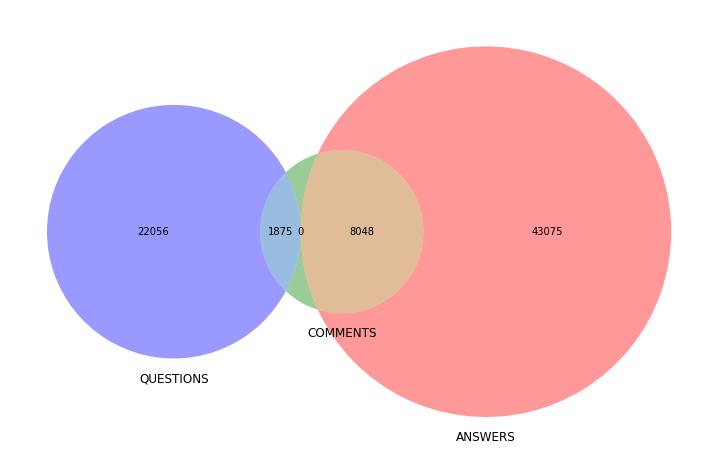

In [13]:
figure(figsize=(20,20))
plt.subplot(1, 2, 1)
venn3([set(ans['answers_id']), set(com['comments_parent_content_id']),set(qs['questions_id'])],
      set_labels = ('ANSWERS','COMMENTS','QUESTIONS' ))

plt.tight_layout()
plt.show()


***The venn diagram shows that both,questions and answers can get commented on.***

***However, answers tend to get more comments than questions.***

**RESPONSE RATES**

Let's inspect the rate of questions getting answered on the platform.

In [14]:
def to_date(val):
    return datetime.strptime( str(val),'%Y-%m-%d %H:%M:%S UTC+0000')
def to_year(val):
    return val.strftime('%Y')
def to_yr_mon(val):
    return val.strftime('%Y-%m')
    
#Question Timestamp Processing    
qs['ts']=qs.apply(lambda x: to_date(x['questions_date_added']),axis=1)
qs['year']=qs.apply(lambda x: to_year(x['ts']),axis=1)
qs['yr_mon']=qs.apply(lambda x: to_yr_mon(x['ts']),axis=1)

#Answer Timestamp Processing    
ans['ts']=ans.apply(lambda x: to_date(x['answers_date_added']),axis=1)
ans['year']=ans.apply(lambda x: to_year(x['ts']),axis=1)

#Question ids that got answered at some point
answered_id= ans['answers_question_id'].unique()

#Questions which never got answered
n_ans=pd.DataFrame(qs.loc[~qs['questions_id'].isin(answered_id)])
n_ans=n_ans.reset_index(drop=True)
n_ans['ts']=n_ans.apply(lambda x: to_date(x['questions_date_added']),axis=1)
n_ans['y_m']=n_ans.apply(lambda x: to_yr_mon(x['ts']),axis=1)
n_ans['yr']=n_ans.apply(lambda x: to_year(x['ts']),axis=1)

#Questions that got answered at some point
y_ans=pd.DataFrame(qs.loc[qs['questions_id'].isin(answered_id)])

#Time taken for replies
ans_gap= pd.merge(ans,y_ans,left_on='answers_question_id',right_on='questions_id')
ans_gap['time_to_answer']= ans_gap.apply(lambda x: (x['ts_x']-x['ts_y']).days ,axis=1 )

#Reply gap tabulated
tab_gap= ans_gap.groupby('time_to_answer').count()[['answers_id']]

#Questions raised by yr-mon
tab_q= qs.groupby('yr_mon').count()[['questions_id']]
tab_q.sort_index()

#Answers given by yr-mon
tab_a= n_ans.groupby('y_m').count()[['questions_id']]

#Answers by year
tab_a_yr = n_ans.groupby('yr').count()[['questions_id']]
#Questions by year
tab_q_yr= qs.groupby('year').count()[['questions_id']]

#Response rates
tab_response_rate=tab_a_yr.join(tab_q_yr,how='outer', lsuffix='_unanswered', rsuffix='_posted')
tab_response_rate=tab_response_rate.fillna(0)
tab_response_rate['response rate']=round(100- ((tab_response_rate['questions_id_unanswered']/tab_response_rate['questions_id_posted'])*100),2)
tab_response_rate.columns=['Questions Unanswered','Questions Posted','Response Rate']
print("RESPONSE RATES OVER THE YEARS")
tab_response_rate

RESPONSE RATES OVER THE YEARS


,Questions Unanswered,Questions Posted,Response Rate
2011,0.0,29,100.00
2012,0.0,435,100.00
2013,0.0,157,100.00
2014,0.0,1007,100.00
2015,0.0,1466,100.00
2016,4.0,9281,99.96
2017,25.0,3255,99.23
2018,712.0,7994,91.09
2019,80.0,307,73.94


***The platform was able to stick to the policy of answering all questions during the years 2011-'15.***


***2018 has seen the lowest response rate of 91%; 712 questions went unanswered.***


***In 2016, there has been a massive increase in questions posted. ***
***Has our student community also grown by so much in 2016??***

***Let's inspect...***

In [15]:
#Professionals Timestamp Processing    
pro['ts']=pro.apply(lambda x: to_date(x['professionals_date_joined']),axis=1)
pro['year']=pro.apply(lambda x: to_year(x['ts']),axis=1)
tab_pro= pro.groupby('year').count()[['professionals_id']]
tab_pro.columns=['Professionals joined each year']
tab_pro['Total Professionals']= tab_pro['Professionals joined each year'].cumsum()

#Students Timestamp Processing    
stu['ts']=stu.apply(lambda x: to_date(x['students_date_joined']),axis=1)
stu['year']=stu.apply(lambda x: to_year(x['ts']),axis=1)
tab_stu= stu.groupby('year').count()[['students_id']]
tab_stu.columns=['Students joined each year']
tab_stu['Total Students']= tab_stu['Students joined each year'].cumsum()
tab_pro_stu= tab_pro.join(tab_stu,how='inner')

print("Size of the community over the years")
tab_pro_stu[:-1]

Size of the community over the years


,Professionals joined each year,Total Professionals,Students joined each year,Total Students
year,,,,
2011,57,57,2,2
2012,222,279,453,455
2013,429,708,570,1025
2014,987,1695,1722,2747
2015,1540,3235,2576,5323
2016,5618,8853,12108,17431
2017,6322,15175,5535,22966
2018,11572,26747,7748,30714


⭐  The highest influx in the student community has been in the year 2016-- 12k students joined that year!

⭐  That is the highest number of students joining the platform in any one year.

⭐  Professionals' community has seen a steady growth, which is a good sign.

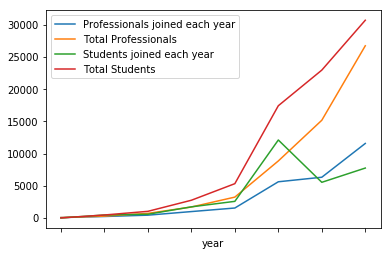

In [16]:
tab_pro_stu[:-1].plot()

**TIME TO RESPOND TO QUESTIONS POSTED**

In [17]:
#Reply gap tabulated
tab_gap= ans_gap.groupby(['time_to_answer']).count()[['answers_id']]
tab_gap['per']=round((tab_gap['answers_id']/tab_gap['answers_id'].sum())*100,2)
print("TIME TO RESPOND TO QUESTIONS")
tab_gap[0:10]

TIME TO RESPOND TO QUESTIONS


,answers_id,per
time_to_answer,,
-1,16,0.03
0,12215,23.89
1,3317,6.49
2,1858,3.63
3,1260,2.46
4,927,1.81
5,712,1.39
6,661,1.29
7,528,1.03


⭐ ** Almost 24% of questions get answered in 24 hours' time.**

NB: The first row may correspond to some glitch in the timestamp recording, answers being posted before questions?

In [18]:
email['ts']= email.apply(lambda x: to_date(x['emails_date_sent']),axis=1)
email['year']= email.apply(lambda x: to_year(x['ts']),axis=1)

emailed_qs = pd.merge(email,match,left_on='emails_id',right_on='matches_email_id')
emailed_qs_ans=pd.merge(emailed_qs,ans,left_on=['emails_recipient_id','matches_question_id'],right_on=['answers_author_id','answers_question_id'],how='inner')

sent     = emailed_qs.groupby(['emails_recipient_id','year']).nunique()[['matches_question_id']] 
responded= emailed_qs_ans.groupby(['emails_recipient_id','year_x']).nunique()[['answers_id']]

sent=sent.reset_index(level=['year'])
responded=responded.reset_index(level=['year_x'])

sent_responded= pd.merge(sent,responded,how='left',left_on=['emails_recipient_id','year'],right_on=['emails_recipient_id','year_x'])
sent_responded=sent_responded.drop('year_x',axis=1)
sent_responded['rate']= np.array((sent_responded['answers_id'] / sent_responded['matches_question_id'])*100)

**Let's explore the tag landscape - questions and users tags **

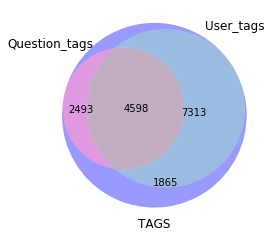

In [19]:
venn3([set(qs_tags['tag_questions_tag_id']), set(user_tag['tag_users_tag_id']),set(tags['tags_tag_id'])],
      set_labels = ('Question_tags','User_tags','TAGS'))

There are question tags that do not match any user's tags and there are users' tags which haven't matched any questions asked so far.

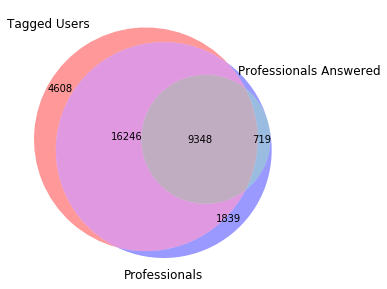

In [20]:
figure(figsize=(5,5))
venn3([set(user_tag['tag_users_user_id']),set(ans_pro['answers_author_id']),set(pro['professionals_id'])],
      set_labels = ('Tagged Users','Professionals Answered','Professionals'))

Out of the ~24k questions posted, almost 10k were matched through emails or at least emails can be thought to be the motivating factor for answering those questions. 

# **Solution 1** <a id=1></a>

# **Find questions from the past most similar to the current question and target professionals who have answered those questions**

**HISTORICAL QUESTIONS ASKED**

In [21]:
qs.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,ts,year,yr_mon
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a maths teacher useful? #college #professor #lecture,2016-04-26 11:14:26,2016,2016-04
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I do to become an army officer?,I am Priyanka from Bangalore . Now am in 10th std . When I go to college I should not get confused on what I want to take to become army officer. So I am asking this question #military #army,2016-05-20 16:48:25,2016,2016-05


Every Question has a title and body. There is a separate table that holds hashtags associated to the question as well.

Let's have a look at this table.

In [22]:
qs_tags.sort_values('tag_questions_question_id')[:10]

,tag_questions_tag_id,tag_questions_question_id
12839,1707,0003e7bf48f24b5c985f8fce96e611f3
59166,33630,0003e7bf48f24b5c985f8fce96e611f3
48543,27510,0003e7bf48f24b5c985f8fce96e611f3
29372,27330,0003e7bf48f24b5c985f8fce96e611f3
23735,18073,0003e7bf48f24b5c985f8fce96e611f3
59956,29649,0003e7bf48f24b5c985f8fce96e611f3
43792,18370,0006609dd4da40dcaa5a83e0499aba14
42995,18360,0006609dd4da40dcaa5a83e0499aba14
32359,18156,000af224bc2f4e94a19f8b62ba279cc4
7919,51,000af224bc2f4e94a19f8b62ba279cc4


⭐  Well, each question can have multiple tags. We have to concatenate these tags and create a **"tag string"** per question (where tags are available)

In [23]:
qs_tagnames= pd.merge(qs_tags,tags,left_on='tag_questions_tag_id',right_on='tags_tag_id')
qs_tagnames=qs_tagnames.drop(['tags_tag_id','tag_questions_tag_id'],axis=1)
print(qs_tagnames.sort_values('tag_questions_question_id')[:10])
qs_tag_pivot=qs_tagnames.pivot_table(index='tag_questions_question_id',values='tags_tag_name',aggfunc=lambda x: " ".join(x))
qs_tag_pivot['tag_questions_question_id']=qs_tag_pivot.index
print("\nNumber of questions asked:",qs['questions_id'].count())
print("Number of questions with tags:",len(qs_tag_pivot))
qs_tag_pivot=qs_tag_pivot.reset_index(drop=True)
print("\n",qs_tag_pivot.head())

              tag_questions_question_id           tags_tag_name
12839  0003e7bf48f24b5c985f8fce96e611f3  internship            
59166  0003e7bf48f24b5c985f8fce96e611f3  majoring              
48543  0003e7bf48f24b5c985f8fce96e611f3  information-technology
29372  0003e7bf48f24b5c985f8fce96e611f3  high-school           
23735  0003e7bf48f24b5c985f8fce96e611f3  technology            
59956  0003e7bf48f24b5c985f8fce96e611f3  time                  
43792  0006609dd4da40dcaa5a83e0499aba14  law                   
42995  0006609dd4da40dcaa5a83e0499aba14  psychology            
32359  000af224bc2f4e94a19f8b62ba279cc4  marine                
7919   000af224bc2f4e94a19f8b62ba279cc4  biology               

Number of questions asked: 23931
Number of questions with tags: 23288

                                                             tags_tag_name         tag_questions_question_id
0  internship technology high-school information-technology majoring time  0003e7bf48f24b5c985f8fce96e611f3
1  psyc

In [24]:
print("Example:\nQuestion id-", qs_tag_pivot.iloc(0)[0]['tag_questions_question_id'],
      ":\n\n",qs.loc[qs['questions_id']==qs_tag_pivot.iloc(0)[0]['tag_questions_question_id']]['questions_body'],
      "\n\n*************************************************************************\nTag string:",
      qs_tag_pivot.iloc(0)[0]['tags_tag_name'])

Example:
Question id- 0003e7bf48f24b5c985f8fce96e611f3 :

 6150    I am a Junior in H.S. right now i am thinking about doing a double major in my tech academy, they have a guaranteed internship if you do this. But i am thinking if its worth it. Two tech classes back to back for the whole senior year. I take college classes at my nearest community college, so i know for a fact that i don't have soo much time to give to something that will not gonna help me or its worth it. \n\n#information-technology  #majoring  #technology \n#internship #time #high-school 
Name: questions_body, dtype: object 

*************************************************************************
Tag string: internship technology high-school information-technology majoring time


**COMBINE QUESTIONS TABLE WITH CORRESPONDING TAGS**

In [25]:
qs_with_tags=pd.merge(qs,qs_tag_pivot,left_on='questions_id',right_on='tag_questions_question_id')
print("Number of questions with tags:",len(qs_with_tags))
qs_with_tags.head(2)

Number of questions with tags: 23288


,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,ts,year,yr_mon,tags_tag_name,tag_questions_question_id
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a maths teacher useful? #college #professor #lecture,2016-04-26 11:14:26,2016,2016-04,lecture college professor,332a511f1569444485cf7a7a556a5e54
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I do to become an army officer?,I am Priyanka from Bangalore . Now am in 10th std . When I go to college I should not get confused on what I want to take to become army officer. So I am asking this question #military #army,2016-05-20 16:48:25,2016,2016-05,military army,eb80205482e4424cad8f16bc25aa2d9c


**Combine question title, body and tags.**

In [26]:
raw_documents=qs_with_tags['questions_title']+qs_with_tags['questions_body']+qs_with_tags['tags_tag_name']
raw_documents.head()

0    Teacher   career   questionWhat  is  a  maths  teacher?   what  is  a  maths  teacher  useful? #college #professor #lecturelecture college professor                                                                                                                                                                                                                                                                                                                                                                                                                                                 
1    I want to become an army officer. What can I do to become an army officer?I am Priyanka from Bangalore . Now am in 10th std . When I go to college I should not get confused on what I want to take to become army officer. So I am asking this question  #military #armymilitary army                                                                                                                                  

**TEXT PROCESSING...**

In [27]:
print("Number of Questions:",len(raw_documents))
print("Tokenizing data...")
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in raw_documents]
print("Creating dictionary...")
dictionary = gensim.corpora.Dictionary(gen_docs)
print("Creating Document-Term Matrix...")
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
print("Creating TF-IDF Model...")
tf_idf = gensim.models.TfidfModel(corpus)
print("Creating Similarity Checker...")
similar_qs = gensim.similarities.Similarity("",tf_idf[corpus],num_features=len(dictionary))
print("Processing Completed!")

Number of Questions: 23288
Tokenizing data...
Creating dictionary...
Creating Document-Term Matrix...
Creating TF-IDF Model...
Creating Similarity Checker...
Processing Completed!


**NEW QUESTION POSTED**

Let's take a fresh question from the website which is not included in the training set:



In [28]:
Query='Can I become data scientist without studying at university?#technology #data-science'
Query

'Can I become data scientist without studying at university?#technology #data-science'

In [29]:
query_doc = [w.lower() for w in word_tokenize(Query)]
query_doc_bow = dictionary.doc2bow(query_doc)
query_doc_tf_idf = tf_idf[query_doc_bow]

**PROCESSING THE QUESTION...**

**CHECKING FOR MOST SIMILAR QUESTIONS FROM THE PAST...**

In [30]:
q_sim=similar_qs[query_doc_tf_idf]

**LET'S SET,
 SIMILARITY THRESHOLD = 0.1**
 
*Any question from the past with a similarity index less than the threshold gets ignored*

In [31]:
sim_threshold=0.10

**DISPLAY THE MOST SIMILAR QUESTIONS FROM THE PAST**

In [32]:
qs_with_tags['Similarity']=q_sim
ques=qs_with_tags[qs_with_tags['Similarity']>=sim_threshold]
ques=ques.sort_values('Similarity',ascending=False)
ques.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,ts,year,yr_mon,tags_tag_name,tag_questions_question_id,Similarity
6864,e0c2a4b991c442ffa70dcdc1cfd2aebc,d969b3d11f2b4317b8391bc51434954a,2014-03-24 03:23:55 UTC+0000,What do data scientists do?,What kind of companies do data scientists work for? How can I become one?\r\n\r\n #data-science #data-analysis #big-data,2014-03-24 03:23:55,2014,2014-03,data-analysis big-data data-science,e0c2a4b991c442ffa70dcdc1cfd2aebc,0.499656
119,beb736d5b2dc49048f7c1b46d5a6b0ea,a527b1588d724854a8dbafaf39421f13,2018-03-26 02:14:50 UTC+0000,What is the difference between data science and machine learning?,"I've been looking into data science careers, and I know that it is closely related with machine learning and big data. I'm confused as to what the difference between data science and machine learning is, and also how big data plays in a part in both fields. What exactly is data science and machine learning, and how are they related to each other (and how does big data tie into them)? Any help would be greatly appreciated.\r\n\r\n#data-analysis #data-science #computer-science #computer-software #big-data #machine-learning #data-visualization #data #data-mining",2018-03-26 02:14:50,2018,2018-03,computer-science computer-software data-analysis big-data machine-learning data data-visualization data-mining data-science,beb736d5b2dc49048f7c1b46d5a6b0ea,0.415093
9703,65ea4a9a749b40a0be5bdd15392b72a0,aef198c7c57d43fda9a6f64b5fad12f6,2018-03-31 03:59:09 UTC+0000,How will the field of education be affected by data science?,I am asking this because I am interested in becoming an instructional designer. #education #data-science #analytics,2018-03-31 03:59:09,2018,2018-03,education analytics data-science,65ea4a9a749b40a0be5bdd15392b72a0,0.403046
2361,8cc3c5d8df3d405d87aa59d042330200,993491dcddd84adab4d341ff5ae7bb83,2018-04-01 20:43:54 UTC+0000,How to become a data scientist?,"Hello,\r\n\r\nI am going to a liberal art college in a fringe town next school year. The school does not have a data science major but I am highly interested in data science. (I will be going to double majors in Computer science and Statistics.) What are some steps should I do to become a data scientist? Is hard to find a data scientists internship in summer? What are some tips during my 4 years of colleges? \r\n\r\n#women-in-stem #technology ##datascience #stemcareers #college-advice #computer-science",2018-04-01 20:43:54,2018,2018-04,computer-science college-advice technology stemcareers women-in-stem datascience,8cc3c5d8df3d405d87aa59d042330200,0.393062
19542,4e6b1b323c3e476ba03c33f75df9304a,a527b1588d724854a8dbafaf39421f13,2018-03-26 02:01:49 UTC+0000,What are the best data science courses/nanodegrees I can take online?,"I'm currently a third year computer science major, and I've recently discovered a passion for data science and machine learning. I've been trying to learn more about it, and I've found many online resources (Udacity's data analyst, machine learning nano degrees, Stanford's Intro to Machine Learning course taught by Andrew Ng, and various courses offered on Udemy). With all of these great resources, which one would be best for someone who is comfortable programming and wants to get more practical experience? Any advice would be very helpful (and even more so if you are a current data scientist!) and would be greatly appreciated!\r\n\r\n#machine-learning #data-analysis #data #big-data #computer-science #computer-software #data-science #data-mining #data-visualization",2018-03-26 02:01:49,2018,2018-03,computer-science computer-software data-analysis big-data machine-learning data data-visualization data-mining data-science,4e6b1b323c3e476ba03c33f75df9304a,0.367709


**IDENTIFY PROFESSIONALS WHO ANSWERED THESE QUESTIONS** 

In [33]:
qlist=ques['questions_id']
qlist_ans=ans[ans['answers_question_id'].isin(qlist)]
prof_answered=set(qlist_ans['answers_author_id'])
#print(prof_answered)
solution1= pro[pro['professionals_id'].isin(prof_answered)]
solution1.head()


,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,ts,year
11,7daf1e6dfb3443b99b240890f0a4d69b,NaN,NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
28,8e75aca48b434c79b8b4729ef871cb50,"Boston, Massachusetts",NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
49,8fa038d69f5647a091c766bf460d2616,NaN,NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
206,29066f5ff3504a91bb7bb304ae6890cb,NaN,NaN,NaN,2012-09-09 04:51:58 UTC+0000,2012-09-09 04:51:58,2012
504,3409d2ee250545558ea03bfdfd8da22e,"New York, New York",Writing and Editing,Social Community Editor at The Huffington Post,2013-09-03 21:11:22 UTC+0000,2013-09-03 21:11:22,2013


*Now that's a good start. But if we only use this method, as mentioned earlier, professionals who haven't answered any questions in the past will be ignored.*

**How big is the population that gets ignored via this method?**

In [34]:
print("Number of professionals registered:",len(pro['professionals_id']))
print("Number of users who have answered:",len(ans['answers_author_id'].unique()))
ans_pro=pro[pro['professionals_id'].isin(ans['answers_author_id'])]
print("Number of professionals who have answered:",len(ans_pro))
ans_stu=stu[stu['students_id'].isin(ans['answers_author_id'])]
print("Number of students who have answered:",len(ans_stu))
print("\n***PROFESSIONALS IGNORED VIA THIS SOLUTION***")
print("Number of professionals who haven't answered yet:",len(set(pro['professionals_id']))-len(ans_pro))

Number of professionals registered: 28152
Number of users who have answered: 10169
Number of professionals who have answered: 10067
Number of students who have answered: 28

***PROFESSIONALS IGNORED VIA THIS SOLUTION***
Number of professionals who haven't answered yet: 18085


In [35]:
print("From the numbers, it is clear that users who identify themselves as neither professionals nor students have answered to questions.\nHow big is this population?\n")
u= set(ans['answers_author_id'])
s= set(stu['students_id'])
p= set(pro['professionals_id'])
st_ansrd= u.intersection(s)
pr_ansrd= u.intersection(p)
all_ansrd= st_ansrd.union(pr_ansrd)
unknwn= u.difference(all_ansrd)
print("Unknown users: ",len(unknwn))

From the numbers, it is clear that users who identify themselves as neither professionals nor students have answered to questions.
How big is this population?

Unknown users:  74


# **Solution 2** <a id=2></a>

# **Identify professionals with tags most similar to the question asked.**

**TAGS PER USER**

Combine user_tag table with tag table.

In [36]:
user_tag_exp=pd.merge(tags,user_tag,left_on='tags_tag_id',right_on='tag_users_tag_id')
user_tag_exp=user_tag_exp.drop(['tags_tag_id','tag_users_tag_id'],axis=1)
user_tag_exp.sort_values('tag_users_user_id')[:10]

,tags_tag_name,tag_users_user_id
111346,content-creation,00009a0f9bda43eba47104e9ac62aff5
130482,script-writing,00009a0f9bda43eba47104e9ac62aff5
77020,digital-media,00009a0f9bda43eba47104e9ac62aff5
16036,accounting,000196ef8db54b9a86ae70ad31745d04
57344,real-estate,0008138be908438e8944b21f7f57f2c1
33607,information-technology,000d4635e5da41e3bfd83677ee11dda4
343,college,000d4635e5da41e3bfd83677ee11dda4
16681,university,000d4635e5da41e3bfd83677ee11dda4
36283,financial-services,000e2b5714444d79a672bf927905135c
36360,financial-services,0018873fbf7742aba1bf13fff12cbfa4


The first user has three tags - content creation, script writing and digital media. This means each user can have multiple tags.

⭐  Concatenate all tags of a user to create a **'tag string'** per user.

**'TAG STRING' TABLE OF USERS**

In [37]:
tag_pivot=user_tag_exp.pivot_table(values='tags_tag_name',index='tag_users_user_id',aggfunc=lambda x: " ".join(x))
tag_pivot['tag_users_user_id']=tag_pivot.index
print("Number of all users with tags:",len(tag_pivot))
tag_pivot=tag_pivot.reset_index(drop=True)
tag_pivot.head()

Number of all users with tags: 30202


,tags_tag_name,tag_users_user_id
0,digital-media content-creation script-writing,00009a0f9bda43eba47104e9ac62aff5
1,accounting,000196ef8db54b9a86ae70ad31745d04
2,real-estate,0008138be908438e8944b21f7f57f2c1
3,college university information-technology,000d4635e5da41e3bfd83677ee11dda4
4,financial-services,000e2b5714444d79a672bf927905135c


This table contains both- students and professionals.

As we are interested in sending emails only to professionals, let's filter this table.

**'TAG STRING' TABLE OF PROFESSIONALS**

In [38]:
pro_tagstring= tag_pivot[tag_pivot['tag_users_user_id'].isin(pro['professionals_id'])]
print("Number of professionals with tags:",len(pro_tagstring))

Number of professionals with tags: 25594


In [39]:
raw_tags=pro_tagstring['tags_tag_name']
print("Tag string table of professionals:")
raw_tags.head()


Tag string table of professionals:


0    digital-media content-creation script-writing
1    accounting                                   
2    real-estate                                  
3    college university information-technology    
4    financial-services                           
Name: tags_tag_name, dtype: object

**TEXT PROCESSING BEGINS...**

In [48]:
print("Number of Tags:",len(raw_tags))
print("Tokenizing data...")
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in raw_tags]
print("Creating dictionary...")
dictionary = gensim.corpora.Dictionary(gen_docs)
print("Creating Document-Term Matrix...")
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
print("Creating TF-IDF Model...")
tf_idf = gensim.models.TfidfModel(corpus)
print("Creating Similarity Checker...")
sims = gensim.similarities.Similarity("",tf_idf[corpus],num_features=len(dictionary))
print("Processing Completed!")

Query='Can I become data scientist without studying at university?#technology #data-science'
print("\nQuestion posted:",Query)


Number of Tags: 25594
Tokenizing data...
Creating dictionary...
Creating Document-Term Matrix...
Creating TF-IDF Model...
Creating Similarity Checker...
Processing Completed!

Question posted: Can I become data scientist without studying at university?#technology #data-science


**CHECKING FOR MOST SIMILAR QUESTIONS FROM THE PAST**

In [41]:
query_doc = [w.lower() for w in word_tokenize(Query)]
query_doc_bow = dictionary.doc2bow(query_doc)
query_doc_tf_idf = tf_idf[query_doc_bow]

In [42]:
sim=sims[query_doc_tf_idf]

**LET'S SET, SIMILARITY THRESHOLD = 0.1**

Any question from the past with a similarity index less than the threshold gets ignored

In [43]:
sim_threshold=0.10

**DISPLAY THE PROFESSIONALS WITH TAGS MOST SIMILAR TO THE QUESTION**

In [44]:
pro_tagstring['sim']=sim
prof_tag=pro_tagstring[pro_tagstring['sim']>=sim_threshold]
prof_tag=prof_tag.sort_values('sim',ascending=False)
prof_tag.head()

,tags_tag_name,tag_users_user_id,sim
4133,data-science data-analysis information-technology-and-services data #innovation #management #technology,2375de66c4374e7eaa459657f711c82f,0.389498
13825,research scientist,76113ae7e9bd44bf841349f62e57d17b,0.351868
33,#business #collegelife #college-major #studying,00594d1a266f4907ac93a689203dacd2,0.334300
18079,information-technology-and-services #consulting #data,9a9c3af208bb4a3caaee623b554a9915,0.324970
17131,hospital-and-health-care #university,92a6fe658c8f48e5bdc6d6c39d215f08,0.314248


In [45]:
prof_list=prof_tag['tag_users_user_id']
solution2= pro[pro['professionals_id'].isin(prof_list)]
solution2.head()

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,ts,year
28,8e75aca48b434c79b8b4729ef871cb50,"Boston, Massachusetts",NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
49,8fa038d69f5647a091c766bf460d2616,NaN,NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
50,70f812ce6f57465fa79531f8c56ecdf8,"Haslet, Texas",NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
51,27c3a6837d9d464387dd90b84288b5cc,NaN,NaN,NaN,2011-12-26 05:00:00 UTC+0000,2011-12-26 05:00:00,2011
54,a0b223a332b94391a5e7cb1440043106,NaN,NaN,NaN,2011-12-29 05:00:00 UTC+0000,2011-12-29 05:00:00,2011


*As mentioned earlier, professionals without any tags will be ignored via this solution.*

**How big is that population?**

In [46]:
print("Number of users with tags:",len(tag_pivot))
print("\nNumber of professionals registered:",len(pro['professionals_id']))

print("Number of professionals with tags:",len(pro_tagstring))

print("\n***PROFESSIONALS IGNORED VIA THIS SOLUTION***")
print("Number of professionals without any tags:",len(set(pro['professionals_id']))-len(pro_tagstring))

Number of users with tags: 30202

Number of professionals registered: 28152
Number of professionals with tags: 25594

***PROFESSIONALS IGNORED VIA THIS SOLUTION***
Number of professionals without any tags: 2558


**Professionals ignored in Solution 2 is far less than in Solution 1**

*Are there professionals who are ignored in both methods?*

Let's inspect this.

In [47]:
answered_pro= set(ans_pro['professionals_id'])
tagged_pro= set(pro_tagstring['tag_users_user_id'])
A1= len(answered_pro.difference(tagged_pro))
B1= len(tagged_pro.difference(answered_pro))
AnB= len(answered_pro.intersection(tagged_pro))
print("Number of professionals ignored via both methods:",len(pro['professionals_id'])-(A1+AnB+B1))

Number of professionals ignored via both methods: 1839


These professionals do not have any tags and haven't responded to any questions yet.

**Further Thoughts:**

One method is to promote these professionals to add tags and that way questions can be directed to them by solution 2.
Once they start answering them, they will also be considered under solution 1.

Another alternative is to suggest tags to these professionals based on their Job Title, Headline, Location etc.

![](http://)